# Exercício MLP e CNN

### Raphael Soares Ramos


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import sys

Usamos transform para gerar novos dados com HorizontalFlip, normalizá-los com média 0.485 e desvio padrão 0.229 e transformar as imagens em tensores. BS é o tamanho do batch!

In [2]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.485,), (0.229,))])
BS = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_set = datasets.FashionMNIST('../datasets', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('../datasets', download=True, train=False, transform=transform)


validation_split = 0.2
split = int(np.floor(validation_split * len(train_set)))

train_set, val_set = torch.utils.data.random_split(train_set, [len(train_set)-split, split])

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BS)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BS)

A seguinte célula pegará o próximo elemento do iterator.

In [5]:
inputs, classes = next(iter(train_loader))

In [6]:
print(len(train_set))

48000


No PyTorch, os tensores são da forma (N, C, H, W), onde N é o tamanho do batch, C é a dimensão do tensor, H é a altura e W é a largura.

Pode-se ver que temos imagens monocromáticas com 28 pixels de largura e 28 de altura no dataset. O tamanho do conjunto de treino é 48000, o conjunto de validação terá 12000 imagens e o de teste 10000.

In [7]:
print(inputs.shape, classes.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Na próxima célula são definidas as redes MLP e CNN. 

#### MLP
Para a rede MLP, primeiro é feito um "flatten" com o método view no tensor de entrada 28x28, que passará a ter tamanho 784. Este novo tensor passará pela então pelas camadas definidas em features. Linear aplica uma transformação Linear (y = xW^T + b). O bias e os pesos serão aprendidos (é possível setar bias para falso). A ReLU, definida por f(x) = max(0,x), é a função de ativação não-linear utilizada para que o modelo seja capaz de aprender transformações não-lineares. Ela é uma das mais utilizadas poe ser quase linear e preservar propriedades interessantes para métodos de descida de gradiente. 

É utilizada um dropout de 30% para evitar overfitting e então, após a última camada Linear, é gerada as probabilidades de cada classe usando LogSoftmax na última camada para calcular o log das probabilidades. 

#### CNN
Para a rede convolucional, são utilizadas duas camadas convolucionais. Ambas com mesmo tamanho de kernel e padding, porém com número de filtros diferentes (16 e 32). Entre cada uma delas é utilizado BatchNorm (melhora performance e estabilidade) e MaxPool para reduzir a dimensionalidade e capturar características em sub-regiões da imagem.

Aqui também é utilizado dropout e LogSoftmax.

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(784, 156), 
            nn.ReLU(), 
            nn.Linear(156, 78),
            nn.ReLU(),
            nn.Linear(78, 39),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(39, 10)
        )
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.features(x)
        return self.out(x)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=5, padding=2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, kernel_size=5, padding=2),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(7*7*32, 10)
        self.out = nn.LogSoftmax(dim=1) 
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)

        return self.out(x)

In [10]:
import copy 


def train_loop(model, cost, data, label, optimizer, phase):    
    # zerar os gradientes
    optimizer.zero_grad()
    
    output = model(data)
    # calcular a loss
    loss = cost(output, label) 
    
    # backward pass: computa o gradiente da perda com respeito aos learnable
    # parameters do modelo
    # atualiza parâmetros do otimizador
    if phase == 'train':
        loss.backward()
        optimizer.step()
    return loss, output


def train(model, dataset, optimizer, cost, scheduler, epochs=20):
    best_acc = 0.
    losses, acc = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    for x in range(epochs):
        print('Epoch {}/{}'.format(x + 1, epochs))
        scheduler.step()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss, running_corrects = 0., 0.
            for batch_idx, (data, labels) in enumerate(dataset[phase]):
                data = data.to(device)
                labels = labels.to(device)
                loss, output = train_loop(model, cost, data, labels, optimizer, phase)
                _, preds = torch.max(output, 1)
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / (BS*len(dataset[phase]))
            epoch_acc = running_corrects.double() / (BS*len(dataset[phase]))
            losses.append(epoch_loss)
            acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))
            if epoch_acc > best_acc and phase == 'val':
                best_acc = copy.deepcopy(epoch_acc)
                best_model_wts = copy.deepcopy(model.state_dict())
        print('-' * 50)
    model.load_state_dict(best_model_wts)
    return model, losses, acc


In [11]:
def test(model, loader, cost):
    model.eval()
    avg_loss, avg_acc, running_corrects = 0., 0., 0.
    y_test, y_pred = [], []
    for batch_idx, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)
        for j in range(output.size()[0]):
            y_test.append(labels.cpu().data[j])
            y_pred.append(preds.cpu().data[j])
        loss = cost(output, labels) 
        running_corrects += torch.sum(preds == labels.data)
        avg_loss += loss.item() * data.size(0)
        avg_acc += running_corrects.double()
    print('Test Loss: {}\nTest Accuracy: {}'.format(avg_loss/(BS*len(loader)), 
                                                    running_corrects.double() / (BS*len(loader))))
    return np.array(y_test), np.array(y_pred)


In [12]:
dataset = {'train': train_loader, 'val': val_loader, 'test': test_loader}

A função de Loss escolhida para treino dos modelos é a NLLLoss devido ao uso do LogSoftmax nos modelos. O otimizador escolhido é o Adam, por ser um método de Learning Rate adaptativa. É utilizado um decaímento exponencial para atualização da learning rate.

Há uma época de treino e uma de validação intercalada para treino de ambos os modelos. A loss na validação ficou um pouco maior do que a loss no treino, o que indica um bom aprendizado do modelo. 

O conjunto de validação é utilizado de forma que os pesos que obterem melhor acurácia no conjunto de validação (também pode-se utilizar os pesos que obterem menor loss no conjunto de validação) serão aqueles utilizados no modelo para o conjunto de teste. 

In [48]:
model = MLP()
model = model.to(device)
cost = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler =  optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1)
model, loss_mlp, acc_mlp = train(model, dataset, optimizer, cost, scheduler)
y_test_mlp, y_pred_mlp = test(model, dataset['test'], cost)

Epoch 1/20
TRAIN Loss: 0.6737 Acc: 0.7608
VAL Loss: 0.4677 Acc: 0.8245
--------------------------------------------------
Epoch 2/20
TRAIN Loss: 0.4686 Acc: 0.8334
VAL Loss: 0.4162 Acc: 0.8435
--------------------------------------------------
Epoch 3/20
TRAIN Loss: 0.4176 Acc: 0.8532
VAL Loss: 0.3865 Acc: 0.8552
--------------------------------------------------
Epoch 4/20
TRAIN Loss: 0.3882 Acc: 0.8627
VAL Loss: 0.3605 Acc: 0.8664
--------------------------------------------------
Epoch 5/20
TRAIN Loss: 0.3619 Acc: 0.8701
VAL Loss: 0.3472 Acc: 0.8738
--------------------------------------------------
Epoch 6/20
TRAIN Loss: 0.3479 Acc: 0.8770
VAL Loss: 0.3488 Acc: 0.8705
--------------------------------------------------
Epoch 7/20
TRAIN Loss: 0.3313 Acc: 0.8819
VAL Loss: 0.3345 Acc: 0.8767
--------------------------------------------------
Epoch 8/20
TRAIN Loss: 0.3163 Acc: 0.8854
VAL Loss: 0.3395 Acc: 0.8775
--------------------------------------------------
Epoch 9/20
TRAIN Loss: 0

In [13]:
cnn = CNN()
cnn = cnn.to(device)
cost = nn.NLLLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
scheduler =  optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1)
model, loss_cnn, acc_cnn = train(cnn, dataset, optimizer, cost, scheduler)
y_test_cnn, y_pred_cnn = test(cnn, dataset['test'], cost)

Epoch 1/20
TRAIN Loss: 0.5096 Acc: 0.8205
VAL Loss: 0.3698 Acc: 0.8670
--------------------------------------------------
Epoch 2/20
TRAIN Loss: 0.3565 Acc: 0.8732
VAL Loss: 0.3206 Acc: 0.8846
--------------------------------------------------
Epoch 3/20
TRAIN Loss: 0.3192 Acc: 0.8859
VAL Loss: 0.2961 Acc: 0.8915
--------------------------------------------------
Epoch 4/20
TRAIN Loss: 0.3035 Acc: 0.8911
VAL Loss: 0.2769 Acc: 0.8979
--------------------------------------------------
Epoch 5/20
TRAIN Loss: 0.2839 Acc: 0.8987
VAL Loss: 0.2668 Acc: 0.9010
--------------------------------------------------
Epoch 6/20
TRAIN Loss: 0.2730 Acc: 0.9029
VAL Loss: 0.2676 Acc: 0.8997
--------------------------------------------------
Epoch 7/20
TRAIN Loss: 0.2631 Acc: 0.9054
VAL Loss: 0.2577 Acc: 0.9055
--------------------------------------------------
Epoch 8/20
TRAIN Loss: 0.2524 Acc: 0.9097
VAL Loss: 0.2498 Acc: 0.9081
--------------------------------------------------
Epoch 9/20
TRAIN Loss: 0

In [37]:
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.metrics import classification_report, confusion_matrix


def plot_confusion_matrix(classes, y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                                    color="white" if cnf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def plot_loss(loss_mlp, loss_cnn):
    epochs = np.arange(1, len(loss_mlp)/2 + 1).astype(np.int)
    loss_train_mlp = np.array([x[1] for x in enumerate(loss_mlp) if x[0]%2==0])
    loss_val_mlp = np.array([x[1] for x in enumerate(loss_mlp) if x[0]%2])
    loss_train_cnn = np.array([x[1] for x in enumerate(loss_cnn) if x[0]%2==0])
    loss_val_cnn = np.array([x[1] for x in enumerate(loss_cnn) if x[0]%2])
    plt.plot(epochs, loss_train_mlp, label='Train MLP')
    plt.plot(epochs, loss_val_mlp, label='Val MLP')
    plt.plot(epochs, loss_train_cnn, label='Train CNN')
    plt.plot(epochs, loss_val_cnn, label='Val CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

def plot_acc(acc_mlp, acc_cnn):
    epochs = np.arange(1, len(acc_mlp)/2 + 1).astype(np.int)
    acc_train_mlp = np.array([x[1] for x in enumerate(acc_mlp) if x[0]%2==0])
    acc_val_mlp = np.array([x[1] for x in enumerate(acc_mlp) if x[0]%2])
    acc_train_cnn = np.array([x[1] for x in enumerate(acc_cnn) if x[0]%2==0])
    acc_val_cnn = np.array([x[1] for x in enumerate(acc_cnn) if x[0]%2])
    plt.plot(epochs, acc_train_cnn, label='Train CNN')
    plt.plot(epochs, acc_val_cnn, label='Val CNN')    
    plt.plot(epochs, acc_train_mlp, label='Train MLP') 
    plt.plot(epochs, acc_val_mlp, label='Val MLP') 
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

Abaixo estão os gráficos e matrizes de confusão para cada um dos modelos. Pelas matrizes de confusão é possível notar que a classe mais confundida é 6 com a 0. Estes números são parecidos, o que confunde o modelo.

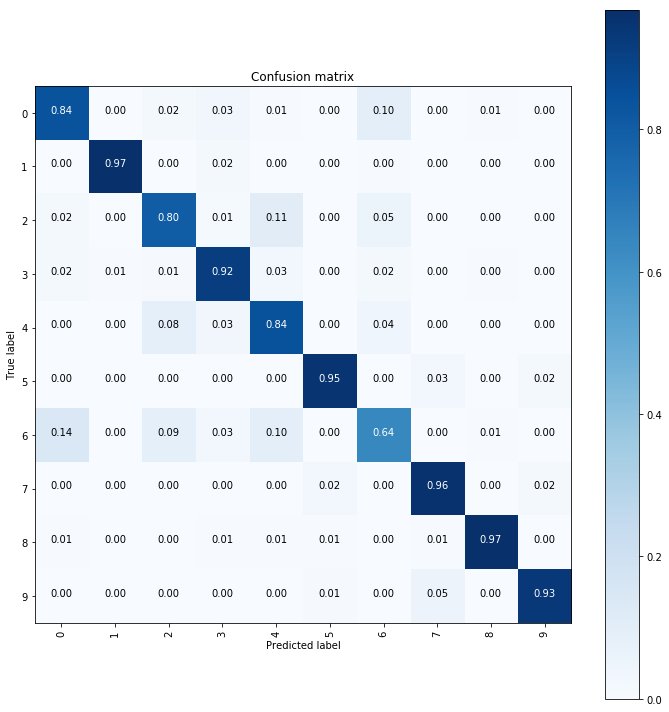

In [15]:
plot_confusion_matrix(np.arange(10), y_test_mlp, y_pred_mlp)

In [16]:
target_names = list(map(lambda x: str(x), np.arange(10)))
print(classification_report(y_test_mlp, y_pred_mlp, target_names=target_names))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.87      0.92      0.89      1000
           4       0.77      0.84      0.80      1000
           5       0.96      0.95      0.95      1000
           6       0.75      0.64      0.69      1000
           7       0.91      0.96      0.94      1000
           8       0.98      0.97      0.97      1000
           9       0.96      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



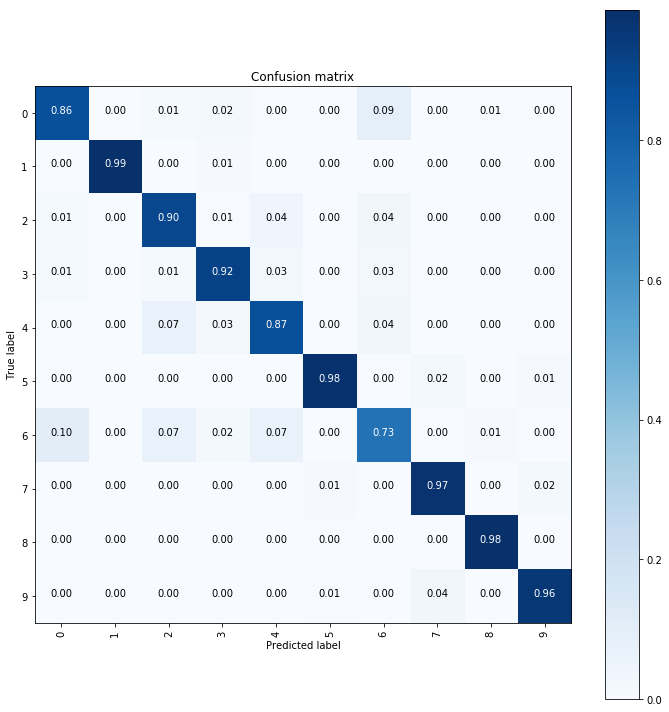

In [17]:
plot_confusion_matrix(np.arange(10), y_test_cnn, y_pred_cnn)

In [18]:
print(classification_report(y_test_cnn, y_pred_cnn, target_names=target_names))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.85      0.90      0.87      1000
           3       0.92      0.92      0.92      1000
           4       0.86      0.87      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.79      0.73      0.76      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.91      0.92      0.91     10000
weighted avg       0.91      0.92      0.91     10000



Os gráficos de desempenho dos modelos nos conjuntos treino e validação são apresentados abaixo.

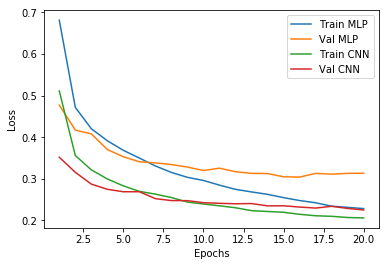

In [38]:
plot_loss(loss_mlp, loss_cnn)

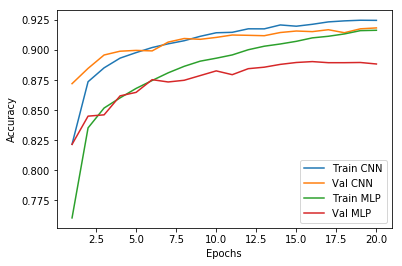

In [39]:
plot_acc(acc_mlp, acc_cnn)